In [81]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from scipy.optimize import curve_fit
from collections import defaultdict
import hypergraphx as hgx
import numpy as np
from community import community_louvain # Louvain algorithm
from scipy.spatial.distance import pdist, squareform
import powerlaw
from tqdm import tqdm
from scipy.stats import poisson
from matplotlib.colors import LogNorm
from scipy.stats import spearmanr, pearsonr


N_S1H2 = 1000  # Larger network for better statistics
gamma_S1H2 = 3.0  # Target power-law exponent
avg_k_S1H2 = 10   # Average degree (higher for better power-law fit)
alpha_S1H2 = 1.5  # Controls clustering

# Angular coordinates (uniform)
theta_S1H2 = np.random.uniform(0, 2 * np.pi, N_S1H2)

# Hidden variables (kappa) from power-law distribution
kappa_0_S1H2 = avg_k_S1H2 * (gamma_S1H2 - 2) / (gamma_S1H2 - 1)  # Corrected formula
U = np.random.uniform(0, 1, N_S1H2)
kappa_S1H2 = kappa_0_S1H2 * (1 - U) ** (-1 / (gamma_S1H2 - 1))

# Precompute constants
mu_S1H2 = alpha_S1H2 * np.sin(np.pi / alpha_S1H2) / (2 * np.pi * avg_k_S1H2)
R_hat_S1H2 = 2 * np.log(N_S1H2 / (mu_S1H2 * np.pi * kappa_0_S1H2 ** 2))

# Radial coordinates
r_S1H2 = R_hat_S1H2 - 2 * np.log(kappa_S1H2 / kappa_0_S1H2)

# Initialize graph
G_S1H2 = nx.Graph()
G_S1H2.add_nodes_from(range(N_S1H2))

# Connect nodes (optimized for larger N)
for i in range(N_S1H2):
    for j in range(i + 1, min(i + 1000, N_S1H2)):  # Limit connections to nearby nodes
        delta_theta = np.pi - abs(np.pi - abs(theta_S1H2[i] - theta_S1H2[j]))
        x_ij = np.arccosh(
            np.cosh(r_S1H2[i]) * np.cosh(r_S1H2[j]) -
            np.sinh(r_S1H2[i]) * np.sinh(r_S1H2[j]) * np.cos(delta_theta)
        )
        p_ij = 1 / (1 + np.exp((alpha_S1H2 / 2) * (x_ij - R_hat_S1H2)))
        if np.random.rand() < p_ij:
            G_S1H2.add_edge(i, j)

# Degree distribution
degrees = [d for _, d in G_S1H2.degree()]
degree_counts = Counter(degrees)
k_values = np.array(list(degree_counts.keys()))
P_k = np.array(list(degree_counts.values())) / N_S1H2

Number of nodes: 1000
Number of edges: 4806
Average degree: 9.61


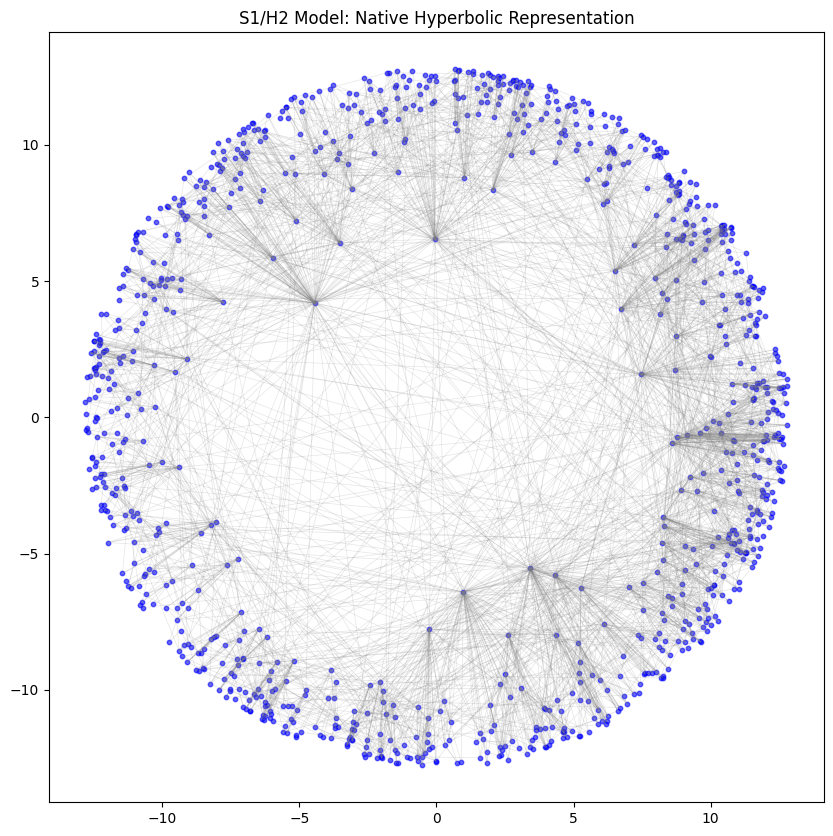

In [82]:
# Print statistics
print(f"Number of nodes: {G_S1H2.number_of_nodes()}")
print(f"Number of edges: {G_S1H2.number_of_edges()}")
print(f"Average degree: {2 * G_S1H2.number_of_edges() / G_S1H2.number_of_nodes():.2f}")

# Plot the network
pos_S1H2 = {
    i: (r_S1H2[i] * np.cos(theta_S1H2[i]), r_S1H2[i] * np.sin(theta_S1H2[i]))
    for i in range(N_S1H2)
}

plt.figure(figsize=(10, 10))
for edge in G_S1H2.edges():
    x0, y0 = pos_S1H2[edge[0]]
    x1, y1 = pos_S1H2[edge[1]]
    plt.plot([x0, x1], [y0, y1], color='gray', linewidth=0.5, alpha=0.2)

x = [pos_S1H2[i][0] for i in G_S1H2.nodes()]
y = [pos_S1H2[i][1] for i in G_S1H2.nodes()]
plt.scatter(x, y, s=10, color='blue', alpha=0.6)

max_r = max(r_S1H2)
plt.xlim(-max_r * 1.1, max_r * 1.1)
plt.ylim(-max_r * 1.1, max_r * 1.1)
plt.title("S1/H2 Model: Native Hyperbolic Representation", fontsize=12)
plt.show()

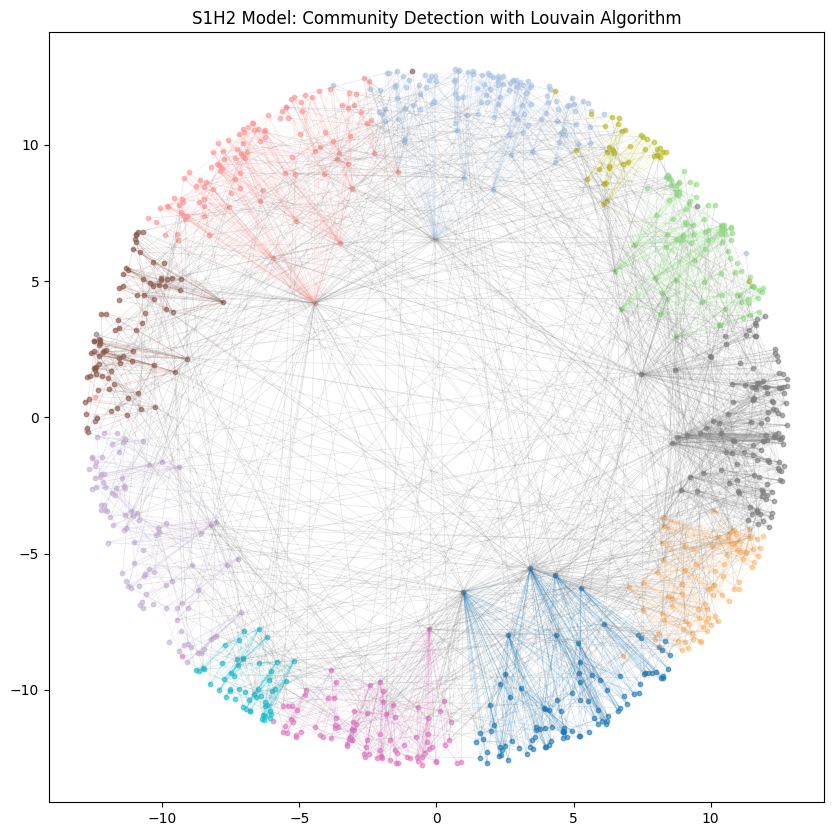

In [83]:
partition = community_louvain.best_partition(G_S1H2)

#: Visualize the network with communities and colored edges
plt.figure(figsize=(10, 10))

# get a list of unique communities
communities = list(set(partition.values()))
colors = plt.cm.tab20  # Use a colormap with 20 distinct colors


# plot edges with community-based coloring
for edge in G_S1H2.edges():
    node1, node2 = edge
    community1 = partition[node1]
    community2 = partition[node2]
    
    # If nodes are in the same community, color the edge the same as the nodes
    if community1 == community2:
        edge_color = colors(community1 / len(communities))
    else:
        edge_color = 'gray'  # Neutral color for inter-community edges
    
    x0, y0 = pos_S1H2[node1]
    x1, y1 = pos_S1H2[node2]
    plt.plot([x0, x1], [y0, y1], color=edge_color, linewidth=0.5, alpha=0.2)

# plot nodes with community colors
for community_id in communities:
    # Get nodes in the current community
    nodes_in_community = [node for node in G_S1H2.nodes() if partition[node] == community_id]
    x = [pos_S1H2[node][0] for node in nodes_in_community]
    y = [pos_S1H2[node][1] for node in nodes_in_community]
    plt.scatter(x, y, s=10, color=colors(community_id / len(communities)), alpha=0.6)

# set plot limits (adjust based on the range of r_S1H2)
max_r = max(r_S1H2)
plt.xlim(-max_r * 1.1, max_r * 1.1)
plt.ylim(-max_r * 1.1, max_r * 1.1)

# remove axes and grid for a cleaner look
#plt.axis('off')

# title
plt.title("S1H2 Model: Community Detection with Louvain Algorithm", fontsize=12)

# show plot
plt.savefig("s1h2_louvain_colored.png", dpi=300, bbox_inches="tight")
plt.show()

In [84]:
print(f"Check avg degree: {2 * G_S1H2.number_of_edges() / N_S1H2:.2f}")

Check avg degree: 9.61


Target γ = 3.00
Fitted γ = 3.03


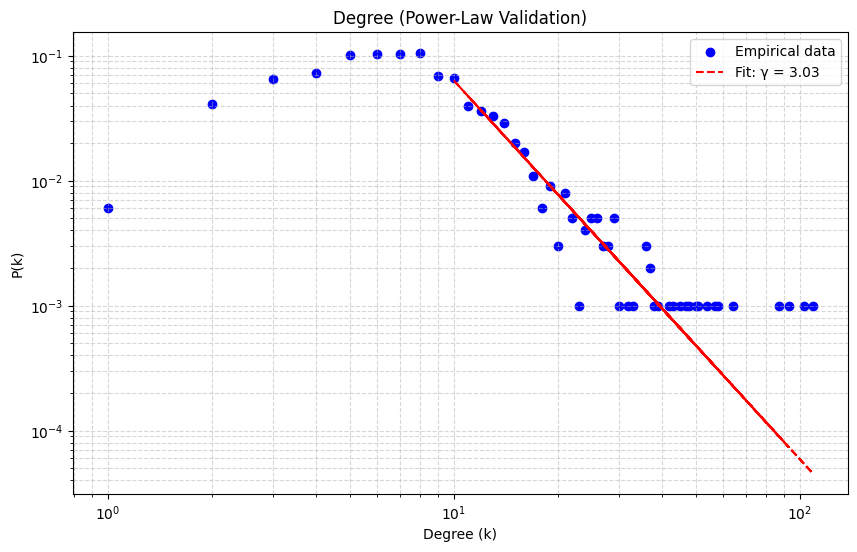

In [85]:
# Fit power law to tail (k >= k_min)
k_min = 10  # Ignore small degrees
tail_mask = k_values >= k_min
log_k = np.log(k_values[tail_mask])
log_P = np.log(P_k[tail_mask])

def power_law(k, gamma, C):
    return C * k ** (-gamma)

popt, _ = curve_fit(power_law, k_values[tail_mask], P_k[tail_mask], p0=[gamma_S1H2, 1])

print(f"Target γ = {gamma_S1H2:.2f}")
print(f"Fitted γ = {popt[0]:.2f}")

# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.scatter(k_values, P_k, label="Empirical data", color="blue")
plt.plot(k_values[tail_mask], power_law(k_values[tail_mask], *popt), 
         label=f"Fit: γ = {popt[0]:.2f}", color="red", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree (Power-Law Validation)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.savefig("s1h2_degreedistributionvalidation.png", dpi=300, bbox_inches="tight")
plt.show()

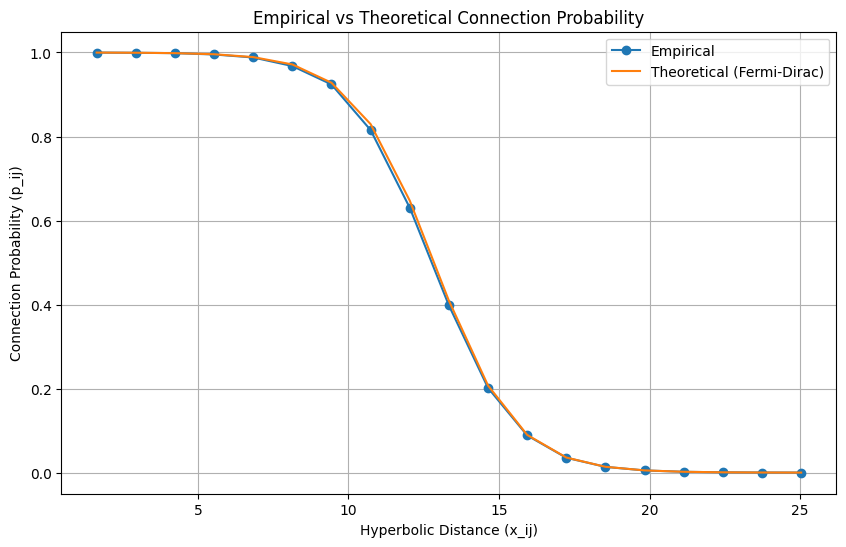

In [86]:
distances = []
probs = []

for i in range(N_S1H2):
    for j in range(i + 1, N_S1H2):
        delta_theta = np.pi - abs(np.pi - abs(theta_S1H2[i] - theta_S1H2[j]))
        x_ij = np.arccosh(np.cosh(r_S1H2[i]) * np.cosh(r_S1H2[j]) - 
               np.sinh(r_S1H2[i]) * np.sinh(r_S1H2[j]) * np.cos(delta_theta))
        p_ij = 1 / (1 + np.exp((alpha_S1H2 / 2) * (x_ij - R_hat_S1H2)))
        distances.append(x_ij)
        probs.append(p_ij)

# bin distances and compute empirical connection probabilities
bins = np.linspace(min(distances), max(distances), 20)
bin_centers = (bins[:-1] + bins[1:]) / 2
empirical_probs = []

for i in range(len(bins) - 1):
    mask = (distances >= bins[i]) & (distances < bins[i + 1])
    if np.sum(mask) > 0:
        empirical_probs.append(np.mean(np.array(probs)[mask]))
    else:
        empirical_probs.append(0)

# theoretical Fermi-Dirac distribution
theoretical_probs = 1 / (1 + np.exp((alpha_S1H2 / 2) * (bin_centers - R_hat_S1H2)))

# Plot empirical vs theoretical connection probabilities
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, empirical_probs, marker='o', label='Empirical')
plt.plot(bin_centers, theoretical_probs, label='Theoretical (Fermi-Dirac)')
plt.xlabel('Hyperbolic Distance (x_ij)')
plt.ylabel('Connection Probability (p_ij)')
plt.title('Empirical vs Theoretical Connection Probability')
plt.legend()
plt.grid()
plt.savefig("s1h2_kotesivaloszinusegeloszlas.png", dpi=300, bbox_inches="tight")
plt.show() #correctly implements the connection rule.

Calculating best minimal value for power law fit
xmin progress: 99%

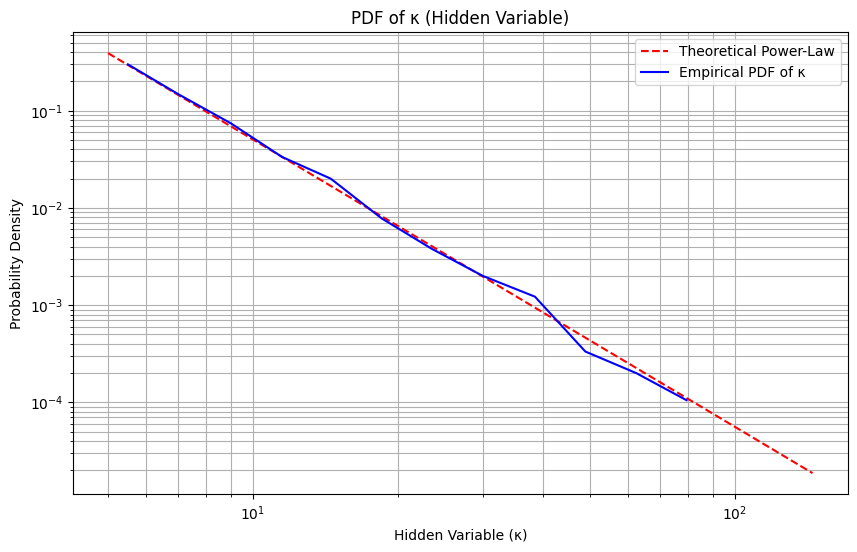

Fitted γ for κ: 2.9521432872080875
Theoretical γ: 3.0


In [87]:
# Fit power-law to kappa
fit_kappa = powerlaw.Fit(kappa_S1H2, discrete=False)  # kappa is continuous

# Plot PDF of kappa vs theoretical power-law
plt.figure(figsize=(10, 6))
fit_kappa.power_law.plot_pdf(color='r', linestyle='--', label='Theoretical Power-Law')
fit_kappa.plot_pdf(color='b', label='Empirical PDF of κ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hidden Variable (κ)')
plt.ylabel('Probability Density')
plt.title('PDF of κ (Hidden Variable)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

# Print fitted gamma for kappa
print(f"Fitted γ for κ: {fit_kappa.power_law.alpha}")
print(f"Theoretical γ: {gamma_S1H2}")

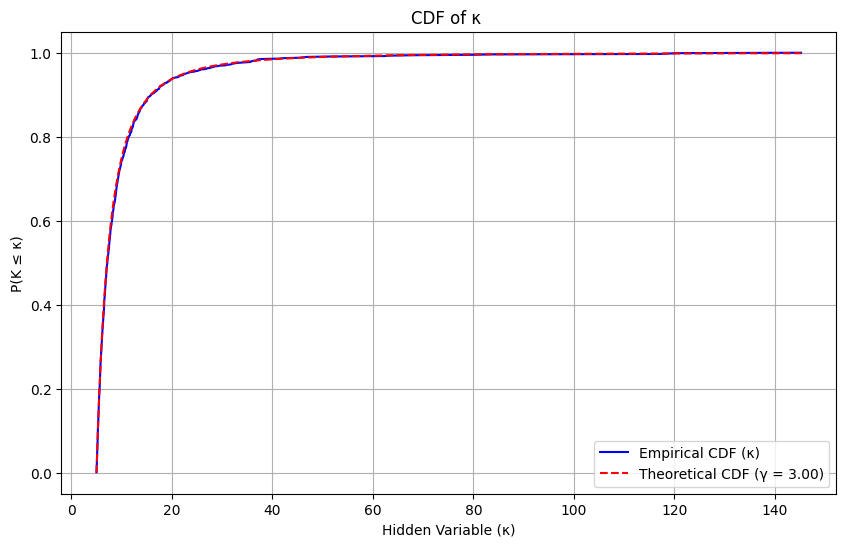

In [88]:
kappa_unique, counts = np.unique(kappa_S1H2, return_counts=True)

# Compute empirical CDF
cdf = np.cumsum(counts) / len(kappa_S1H2)
kappa_min = kappa_0_S1H2  # Minimum kappa value
cdf_theoretical = 1 - (kappa_unique / kappa_min) ** (1 - gamma_S1H2)
plt.figure(figsize=(10, 6))
plt.plot(kappa_unique, cdf, 'b-', label='Empirical CDF (κ)')
plt.plot(kappa_unique, cdf_theoretical, 'r--', 
         label=f'Theoretical CDF (γ = {gamma_S1H2:.2f})')

plt.xlabel('Hidden Variable (κ)')
plt.ylabel('P(K ≤ κ)')
plt.title('CDF of κ ')
plt.legend()
plt.grid(True)
plt.show()

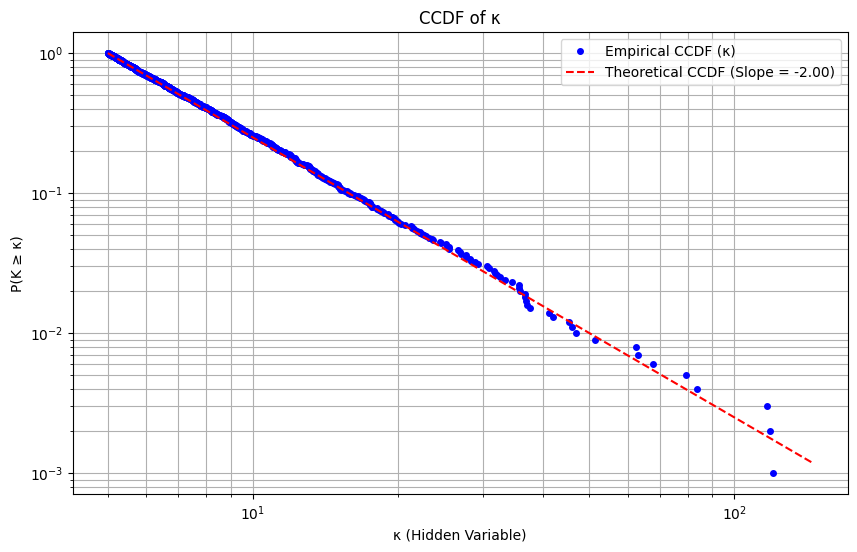

In [89]:
ccdf = 1 - cdf
plt.figure(figsize=(10, 6))
plt.loglog(kappa_unique, ccdf, 'bo', markersize=4, label='Empirical CCDF (κ)')

# Theoretical power-law CCDF (slope = 1 - γ)
k_min = kappa_0_S1H2  # Minimum kappa value
k_grid = np.logspace(np.log10(k_min), np.log10(max(kappa_unique)), 100)
ccdf_theoretical = (k_grid / k_min) ** (1 - gamma_S1H2)

plt.loglog(k_grid, ccdf_theoretical, 'r--', 
           label=f'Theoretical CCDF (Slope = {1 - gamma_S1H2:.2f})')

plt.xlabel('κ (Hidden Variable)')
plt.ylabel('P(K ≥ κ)')
plt.title('CCDF of κ')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.savefig("s1h2_kappaccdf.png", dpi=300, bbox_inches="tight")
plt.show()

In [90]:
def generate_hypergraph_S1H2(edge_size_distribution, node_positions, gamma=3.0, alpha=1.5, avg_k=10):
    """Generate hypergraph using actual S1H2 connection probabilities"""
    H = hgx.Hypergraph()
    N = len(node_positions)
    existing_hyperedges = set()
    
    # Calculate R_hat (connection threshold)
    kappa_0 = avg_k * (gamma - 2) / (gamma - 1)
    mu = alpha * np.sin(np.pi / alpha) / (2 * np.pi * avg_k)
    R_hat = 2 * np.log(N / (mu * np.pi * kappa_0 ** 2))
    
    for size in edge_size_distribution:
        if size < 2: continue
        
        while True:
            # Select anchor node
            anchor = np.random.choice(N)
            r_anchor, theta_anchor = node_positions[anchor]
            
            # Calculate distances using S1H2 metric
            distances = []
            for j in range(N):
                if j == anchor: continue
                r_j, theta_j = node_positions[j]
                delta_theta = np.pi - abs(np.pi - abs(theta_anchor - theta_j))
                x_ij = np.arccosh(
                    np.cosh(r_anchor)*np.cosh(r_j) - 
                    np.sinh(r_anchor)*np.sinh(r_j)*np.cos(delta_theta)
                )
                
                # Use S1H2 connection probability
                p_ij = 1 / (1 + np.exp((alpha/2)*(x_ij - R_hat)))
                if np.random.rand() < p_ij:
                    distances.append((j, x_ij))
            
            # If we have enough connections, form hyperedge
            if len(distances) >= size-1:
                distances.sort(key=lambda x: x[1])
                hyperedge = tuple(sorted([anchor] + [x[0] for x in distances[:size-1]]))
                
                if hyperedge not in existing_hyperedges:
                    existing_hyperedges.add(hyperedge)
                    H.add_edge(list(hyperedge))
                    break
    
    return H

# Generate hypergraph using S1H2 parameters
n_hyperedges = 1000
hyperedge_sizes = np.clip(np.random.poisson(lam=3, size=n_hyperedges), 2, 10) + 2

# Create node positions dictionary from S1H2 coordinates
node_positions = {i: (r_S1H2[i], theta_S1H2[i]) for i in range(N_S1H2)}

H_poisson = generate_hypergraph_S1H2(
    hyperedge_sizes,
    node_positions,
    gamma=gamma_S1H2,
    alpha=alpha_S1H2,
    avg_k=avg_k_S1H2
)

In [91]:
print(f"Generated {len(H_poisson.get_edges())} hyperedges")
print(f"Hyperedge size distribution: {Counter(len(e) for e in H_poisson.get_edges())}")

Generated 1000 hyperedges
Hyperedge size distribution: Counter({4: 401, 5: 255, 6: 160, 7: 98, 8: 51, 9: 24, 10: 7, 11: 3, 12: 1})


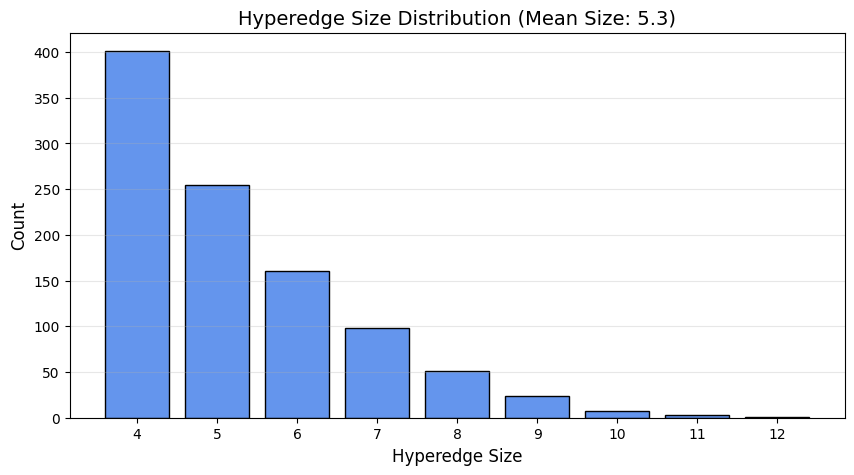

In [92]:

# Use H_poisson
sizes = [len(e) for e in H_poisson.get_edges()]
size_counts = Counter(sizes)

# Plot with improved formatting
plt.figure(figsize=(10, 5))
plt.bar(size_counts.keys(), size_counts.values(), 
       color='cornflowerblue', edgecolor='black')

# Customize plot
plt.xticks(list(size_counts.keys()))
plt.xlabel('Hyperedge Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Hyperedge Size Distribution (Mean Size: {np.mean(sizes):.1f})', 
         fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.savefig("hyperedgesizedistr.png", dpi=300, bbox_inches="tight")
plt.show()

In [93]:
def analyze_hypergraph_hubs(H, node_positions, percentile=95):
    """
    Analyzes hub nodes without modifying the original hypergraph.
    Returns hub information while preserving existing results.
    """
    # 1. Calculate hyperdegrees (doesn't modify H)
    hyperdegrees = np.zeros(len(node_positions))
    for edge in H.get_edges():
        for node in edge:
            hyperdegrees[node] += 1
    
    # 2. Identify hubs (top 5% by default)
    hub_threshold = np.percentile(hyperdegrees, percentile)
    hubs = np.where(hyperdegrees >= hub_threshold)[0]
    
    # 3. Calculate hub statistics (no modification)
    hub_stats = {
        'count': len(hubs),
        'mean_hyperdegree': np.mean(hyperdegrees[hubs]),
        'max_hyperdegree': np.max(hyperdegrees),
        'hub_nodes': hubs,
        'hyperdegrees': hyperdegrees  # Optional: return all hyperdegrees
    }
    
    return hub_stats

# Usage example
hub_info = analyze_hypergraph_hubs(H_poisson, node_positions)

print(f"\nHub Analysis Results (Preserving Original Hypergraph):")
print(f"- Found {hub_info['count']} hub nodes (top 5%)")
print(f"- Max hyperdegree: {hub_info['max_hyperdegree']}")
print(f"- Hub nodes: {hub_info['hub_nodes']}")


Hub Analysis Results (Preserving Original Hypergraph):
- Found 61 hub nodes (top 5%)
- Max hyperdegree: 59.0
- Hub nodes: [ 19  26  29  33  68  84 100 104 121 145 153 186 188 193 221 227 300 305
 316 358 375 381 384 402 404 450 451 475 500 519 543 553 554 556 577 606
 621 622 628 630 651 718 721 764 800 803 807 824 865 896 898 902 917 920
 930 932 935 964 983 989 992]


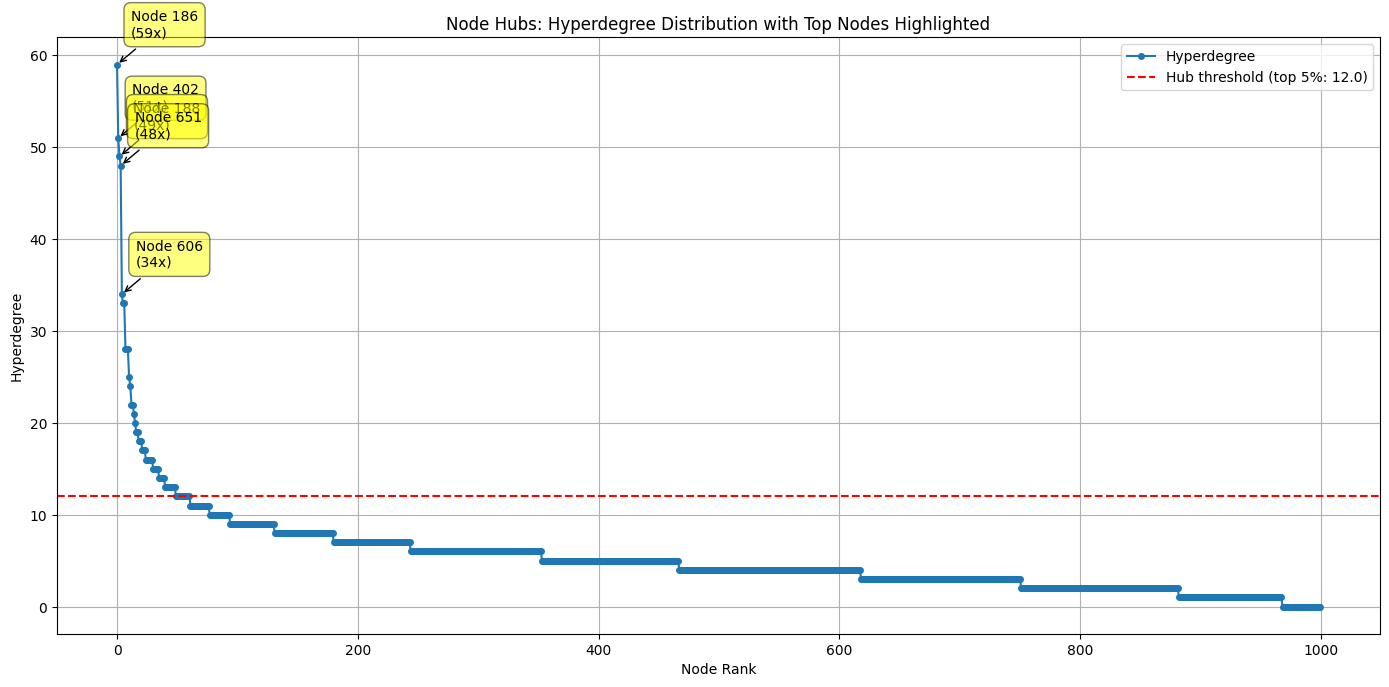


Hub nodes (top 5% with hyperdegree ≥ 12.0):
Node 19: 12 connections
Node 26: 17 connections
Node 29: 19 connections
Node 33: 17 connections
Node 68: 12 connections
Node 84: 15 connections
Node 100: 15 connections
Node 104: 16 connections
Node 121: 12 connections
Node 145: 22 connections
Node 153: 19 connections
Node 186: 59 connections
Node 188: 49 connections
Node 193: 13 connections
Node 221: 28 connections
Node 227: 13 connections
Node 300: 12 connections
Node 305: 15 connections
Node 316: 14 connections
Node 358: 12 connections
Node 375: 18 connections
Node 381: 16 connections
Node 384: 12 connections
Node 402: 51 connections
Node 404: 13 connections
Node 450: 24 connections
Node 451: 14 connections
Node 475: 20 connections
Node 500: 14 connections
Node 519: 17 connections
Node 543: 13 connections
Node 553: 14 connections
Node 554: 28 connections
Node 556: 22 connections
Node 577: 13 connections
Node 606: 34 connections
Node 621: 16 connections
Node 622: 25 connections
Node 628: 1

In [94]:



hyperdegrees = hub_info['hyperdegrees']

# Node hubs visualization 
plt.figure(figsize=(14, 7))

# Sort nodes by hyperdegree
sorted_indices = np.argsort(hyperdegrees)[::-1]
sorted_hd = hyperdegrees[sorted_indices]
plt.plot(sorted_hd, 'o-', markersize=4, label='Hyperdegree')

# Hub threshold
hub_threshold = np.percentile(hyperdegrees, 95)
plt.axhline(y=hub_threshold, color='r', linestyle='--', 
            label=f'Hub threshold (top 5%: {hub_threshold:.1f})')

# Annotate top nodes 
top_5_indices = np.argsort(hyperdegrees)[-5:][::-1]
for i, idx in enumerate(top_5_indices):
    plt.annotate(f'Node {idx}\n({int(hyperdegrees[idx])}x)',
                xy=(np.where(sorted_indices == idx)[0][0], hyperdegrees[idx]),
                xytext=(10, 20), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->'))

plt.xlabel('Node Rank')
plt.ylabel('Hyperdegree')
plt.title('Node Hubs: Hyperdegree Distribution with Top Nodes Highlighted')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("nodehubhyperdegree.png", dpi=300, bbox_inches="tight")
plt.show()

# Print hub information
hub_nodes = np.where(hyperdegrees >= hub_threshold)[0]
print(f"\nHub nodes (top 5% with hyperdegree ≥ {hub_threshold:.1f}):")
for node in hub_nodes:
    print(f"Node {node}: {int(hyperdegrees[node])} connections")

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 27310.40it/s]


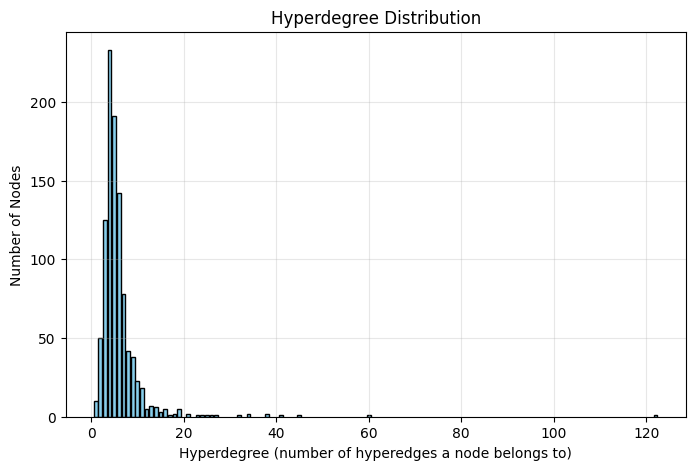

In [95]:


# Generate hyperedge sizes (one per anchor)
hyperedge_sizes = poisson.rvs(mu=4, size=N) + 2  # Minimum size 2

# Count hyperdegrees
participation_counts = np.zeros(N, dtype=int)

for anchor in tqdm(range(N)):
    k = hyperedge_sizes[anchor]
    sorted_nodes = np.argsort(dist_matrix[anchor])
    sorted_nodes = sorted_nodes[1:]  
    selected = sorted_nodes[:k-1]
    participation_counts[anchor] += 1
    participation_counts[selected] += 1

# Plot degree distribution
degree_counts = Counter(participation_counts)
degrees, counts = zip(*sorted(degree_counts.items()))

plt.figure(figsize=(8, 5))
plt.bar(degrees, counts, color='skyblue', edgecolor='black')
plt.xlabel('Hyperdegree (number of hyperedges a node belongs to)')
plt.ylabel('Number of Nodes')
plt.title('Hyperdegree Distribution')
plt.grid(True, alpha=0.3)
plt.show()

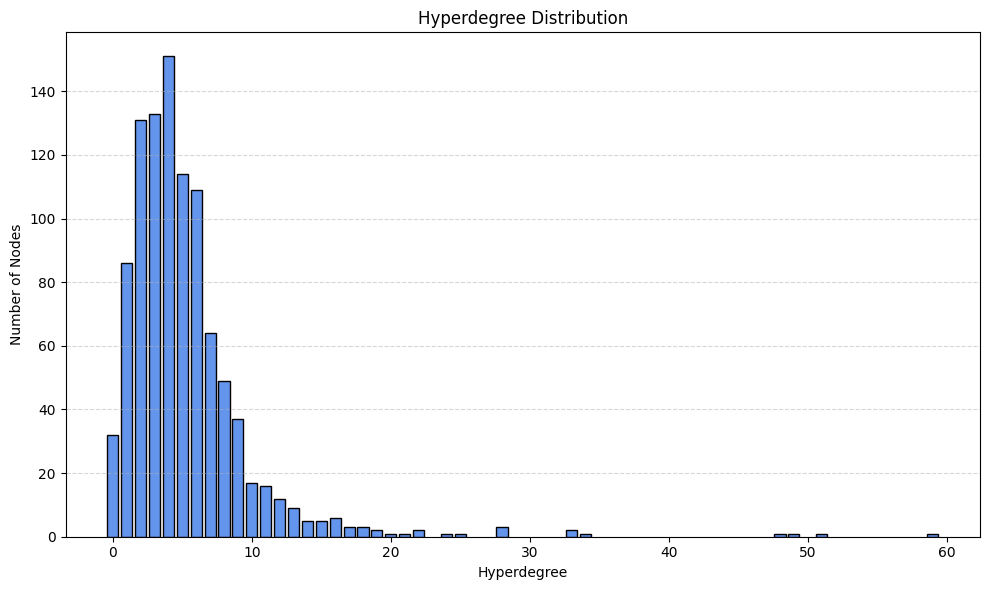

In [96]:
sorted_hd = hyperdegrees[sorted_indices]

# Count how many times each hyperdegree appears in the ranking array
hd_distribution = Counter(sorted_hd)

# Prepare plot data
degrees = sorted(hd_distribution)
counts = [hd_distribution[d] for d in degrees]

# Plot the hyperdegree distribution
plt.figure(figsize=(10, 6))
plt.bar(degrees, counts, color='cornflowerblue', edgecolor='black')
plt.xlabel('Hyperdegree')
plt.ylabel('Number of Nodes')
plt.title('Hyperdegree Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("hyperdegreedistr.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

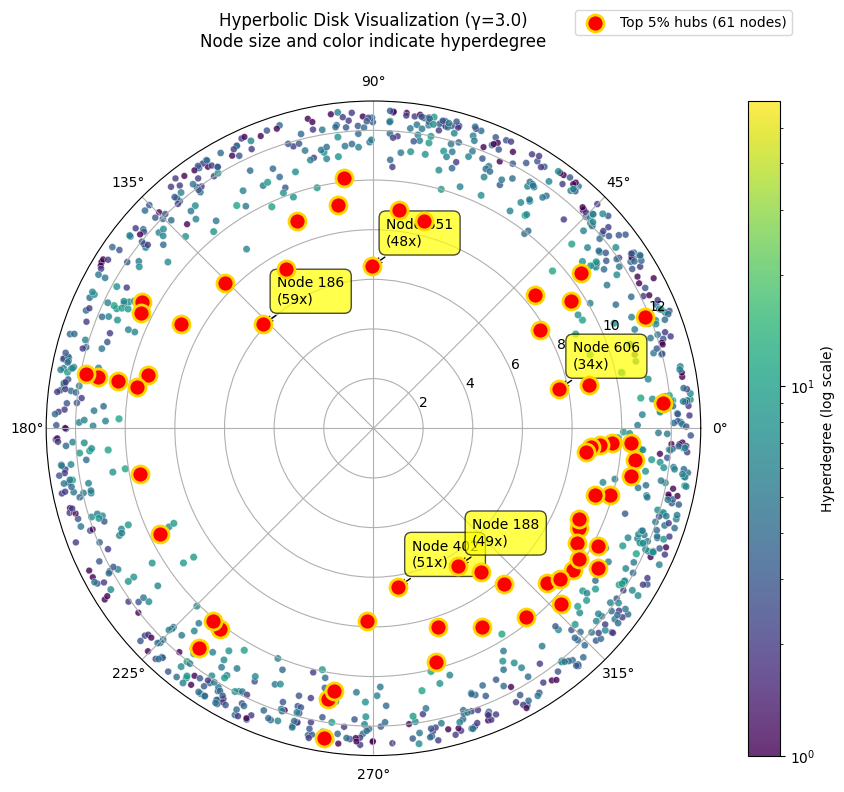

=== Hypergraph Metrics (γ=3.0) ===
Total hyperedges: 1000
Mean hyperdegree: 5.3 ± 5.0
Max hyperdegree: 59 (Node 186)
Hub threshold (top 5%): 12.0 hyperdegree
Hub nodes: [ 19  26  29  33  68  84 100 104 121 145 153 186 188 193 221 227 300 305
 316 358 375 381 384 402 404 450 451 475 500 519 543 553 554 556 577 606
 621 622 628 630 651 718 721 764 800 803 807 824 865 896 898 902 917 920
 930 932 935 964 983 989 992]
Hub concentration: 6.1% of nodes


In [97]:

def plot_hyperbolic_disk(node_positions, hyperdegrees, gamma):
    """Plot nodes on hyperbolic disk with hub highlighting"""
    # Calculate hubs (top 5%)
    hub_threshold = np.percentile(hyperdegrees, 95)
    hubs = np.where(hyperdegrees >= hub_threshold)[0]
    
    r = np.array([pos[0] for pos in node_positions.values()])
    theta = np.array([pos[1] for pos in node_positions.values()])
    
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, projection='polar')
    
    # Plot all nodes with size and color scaled by hyperdegree
    sc = ax.scatter(theta, r, c=hyperdegrees,
                   cmap='viridis', norm=LogNorm(),
                   s=20 + 3*np.sqrt(hyperdegrees),
                   alpha=0.8, edgecolors='white', linewidth=0.3)
    
    # Highlight hubs with preferred style
    ax.scatter(theta[hubs], r[hubs],
              c='red', s=150, edgecolors='gold',
              linewidths=2, label=f'Top 5% hubs ({len(hubs)} nodes)',
              zorder=10)
    
    # Annotate top 5 hubs
    top_5_indices = np.argsort(hyperdegrees)[-5:][::-1]
    for idx in top_5_indices:
        ax.annotate(f'Node {idx}\n({int(hyperdegrees[idx])}x)',
                   xy=(theta[idx], r[idx]),
                   xytext=(10, 15), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.colorbar(sc, label='Hyperdegree (log scale)')
    ax.set_title(f'Hyperbolic Disk Visualization (γ={gamma})\n'
                f'Node size and color indicate hyperdegree', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
    plt.tight_layout()
    plt.savefig("hyperdisk.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Print metrics
    print(f"=== Hypergraph Metrics (γ={gamma}) ===")
    print(f"Total hyperedges: {len(H_poisson.get_edges())}")
    print(f"Mean hyperdegree: {np.mean(hyperdegrees):.1f} ± {np.std(hyperdegrees):.1f}")
    print(f"Max hyperdegree: {int(np.max(hyperdegrees))} (Node {np.argmax(hyperdegrees)})")
    print(f"Hub threshold (top 5%): {hub_threshold:.1f} hyperdegree")
    print(f"Hub nodes: {hubs}")
    print(f"Hub concentration: {len(hubs)/len(node_positions)*100:.1f}% of nodes")

# Run visualization using existing variables
plot_hyperbolic_disk(node_positions, hyperdegrees, gamma_S1H2)

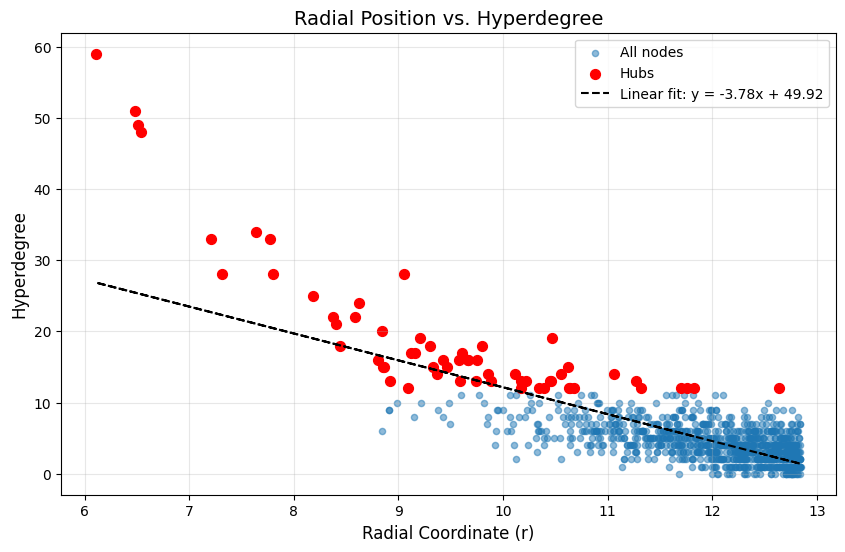

=== Radial-Hyperdegree Correlation ===
Pearson r: -0.762 (p-value: 2.598e-190)
Spearman ρ: -0.595 (p-value: 5.326e-97)

Interpretation:
- Negative coefficient: Higher hyperdegree near center (small r)
- Positive coefficient: Higher hyperdegree at periphery (large r)


In [98]:

def plot_radial_hyperdegree(r, hyperdegrees, hubs):
    """Scatter plot with regression line and hub highlighting"""
    plt.figure(figsize=(10, 6))
    
    # Main scatter plot
    plt.scatter(r, hyperdegrees, alpha=0.5, s=20, label='All nodes')
    
    # Highlight hubs
    plt.scatter(r[hubs], hyperdegrees[hubs], c='red', s=50, label='Hubs')
    
    # Add regression line
    coeffs = np.polyfit(r, hyperdegrees, 1)
    reg_line = np.polyval(coeffs, r)
    plt.plot(r, reg_line, 'k--', 
             label=f'Linear fit: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')
    
    plt.xlabel('Radial Coordinate (r)', fontsize=12)
    plt.ylabel('Hyperdegree', fontsize=12)
    plt.title('Radial Position vs. Hyperdegree', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig("radialpositionhyperdegree.png", dpi=300, bbox_inches="tight")
    plt.show()

def radial_hyperdegree_correlation(r, hyperdegrees):
    """Calculate and print correlation metrics"""
    pearson_r, pearson_p = pearsonr(r, hyperdegrees)
    spearman_r, spearman_p = spearmanr(r, hyperdegrees)
    
    print("=== Radial-Hyperdegree Correlation ===")
    print(f"Pearson r: {pearson_r:.3f} (p-value: {pearson_p:.3e})")
    print(f"Spearman ρ: {spearman_r:.3f} (p-value: {spearman_p:.3e})")
    print("\nInterpretation:")
    print("- Negative coefficient: Higher hyperdegree near center (small r)")
    print("- Positive coefficient: Higher hyperdegree at periphery (large r)")

# Get radial coordinates
r = np.array([pos[0] for pos in node_positions.values()])

# Run analysis
plot_radial_hyperdegree(r, hyperdegrees, hub_info['hub_nodes'])
radial_hyperdegree_correlation(r, hyperdegrees)